# EJERCICIOS

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import seaborn as sns

In [2]:
from tensorflow.keras.datasets import mnist # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Input # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

## EJERCICIO 1

¿Cuántas neuronas hacen falta en la capa de salida para clasificar emails entre correo no deseado y correo deseado? 

1 neurona, es una clasificación binaria

¿Qué función de activación deberías usar en la capa de salida? 

Sigmoide, para que sea entre 0 y 1

Si, en cambio, quieres enfrentarte a MNIST, ¿cuántas neuronas necesitas en la capa de salida y qué función de activación deberías usar? 
10, porque son del 0 al 9. Usaría softmax que usa probabilidades. 


¿Y si quieres que la red prediga los precios de la vivienda en California?
1 neurona, es un problema de regresión que devuelve un valor único y sin función 

## EJERCICIO 2

Entrena un red neuronal profunda con el conjunto de datos MNIST (puedes cargarlo con tf. keras. datasets.minst.load_data()). Intenta conseguir la mejor pruebas en el conjunto de validación  ajustando los hiperparámetros de modo manual. Prueba a buscar una buena tasa de aprendizaje y utiliza la detención temprana (mínimo hay que conseguir un 97%).

Pasos a seguir: 
+ Entrena varios modelos con distintas tasas de aprendizaje
+ Guarda cada modelo en un fichero
+ Carga cada modelo y evalúalo en el conjunto de cargas y quedate con programación con el mejor (bucle que se quede con el mejor), mostrando la tasa de aprendizaje y la exactitud del mejor modelo.

Si no obtienes más de un 97% vuelve a empezar.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

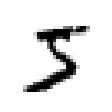

In [5]:
plt.figure(figsize=(1.2, 1.2))
plt.imshow(x_train[0], cmap="binary",interpolation="nearest")
plt.axis('off')
plt.show()

Hago una función para crear un modelo que recibe el learning rate

In [6]:
def crear_modelo(learning_rate):
    modelo = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    optimizador = Adam(learning_rate=learning_rate)
    
    modelo.compile(
        optimizer=optimizador,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return modelo


Pasarle a la función diferentes learning rates

In [9]:
tasas_aprendizaje = [0.001, 0.01, 0.1]
mejores_resultados = []

for lr in tasas_aprendizaje:
    modelo = crear_modelo(lr)
    
    # Entrenar modelo
    historia = modelo.fit(
        x_train, y_train, 
        validation_split=0.2,
        epochs=20,
        verbose=0
    )
    
    # Guardar modelo
    modelo.save(f'modelo_lr_{lr}.keras')

mejor_modelo = None
mejor_exactitud = 0

for lr in tasas_aprendizaje:
    # Cargar modelo
    modelo = tf.keras.models.load_model(f'modelo_lr_{lr}.h5')
    
    # Evaluar modelo
    perdida, exactitud = modelo.evaluate(x_test, y_test)
    
    # Guardar resultados
    mejores_resultados.append({
        'learning_rate': lr,
        'accuracy': exactitud
    })
    
    # Actualizar el mejor modelo si es necesario
    if exactitud > mejor_exactitud:
        mejor_exactitud = exactitud
        mejor_modelo = modelo

mejores_resultados = pd.DataFrame(mejores_resultados)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9775 - loss: 0.1272


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9593 - loss: 0.2606


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2109 - loss: 2.0147


Seleccionar mejor modelo

In [15]:
# Find the index of the row with the highest accuracy
mejor_indice = mejores_resultados['accuracy'].idxmax()

# Get the row with the best accuracy
mejor_modelo = mejores_resultados.loc[mejor_indice]

print(f"Mejor tasa de aprendizaje: {mejor_modelo['learning_rate']}")
print(f"Exactitud: {mejor_modelo['accuracy']}")

Mejor tasa de aprendizaje: 0.001
Exactitud: 0.9804999828338623


Si tiene > 97% OK, si no, volver a empezar

## EJERCICIO 3

Clasificación de Imágenes de Dígitos Escritos a Mano:

* Objetivo: Entrenar una red neuronal para clasificar imágenes de dígitos escritos a mano utilizando el conjunto de datos SVHN (Street View House Numbers).

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos representando alguna imagen con su etiqueta y muestra los valores (únicos) de y (en el entrenamiento, en validación y en pruebas), preparar los datos (d normalizar dividiendo entre 255.0 e igual hay que hacer algo más), construir, compilar y entrenar una red neuronal. 

    * Utilizar detección temprana

    * Hacer una gráfica de como evoluciona accuracy y val_accuracy durante el entrenamiento

    * Si es necesario ajustar el modelo para lograr una mayor precisión.

    * Evalúar el modelo en el conjunto de test y hacer alguna predicción (representa alguna imagen con su etiqueta real y la predicha)

In [28]:
def load_svhn_data(url):
    path = tf.keras.utils.get_file("svhn.mat", url)
    data = loadmat(path)
    return np.transpose(data["X"], (3, 0, 1, 2)), data["y"].flatten()

# Cargar datos
train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
test_url = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
X_train_full, y_train_full = load_svhn_data(train_url)
X_test, y_test = load_svhn_data(test_url)

In [29]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

def display_image(data, tag=""):
    plt.figure(figsize=(6, 6))
    plt.imshow(data)
    plt.axis('off') 
    if tag:
        plt.title(tag)
    plt.show()

def display_many(data, tags, rows, cols):
    # cuadrícula de imágenes
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i])
        ax.axis('off')
        ax.set_title(tags[i])

    plt.tight_layout()
    plt.show()

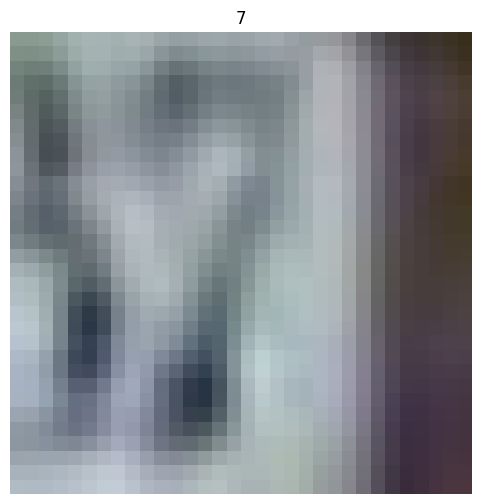

In [30]:
# Mostrar una imagen individual
display_image(X_train[0],y_train[0])


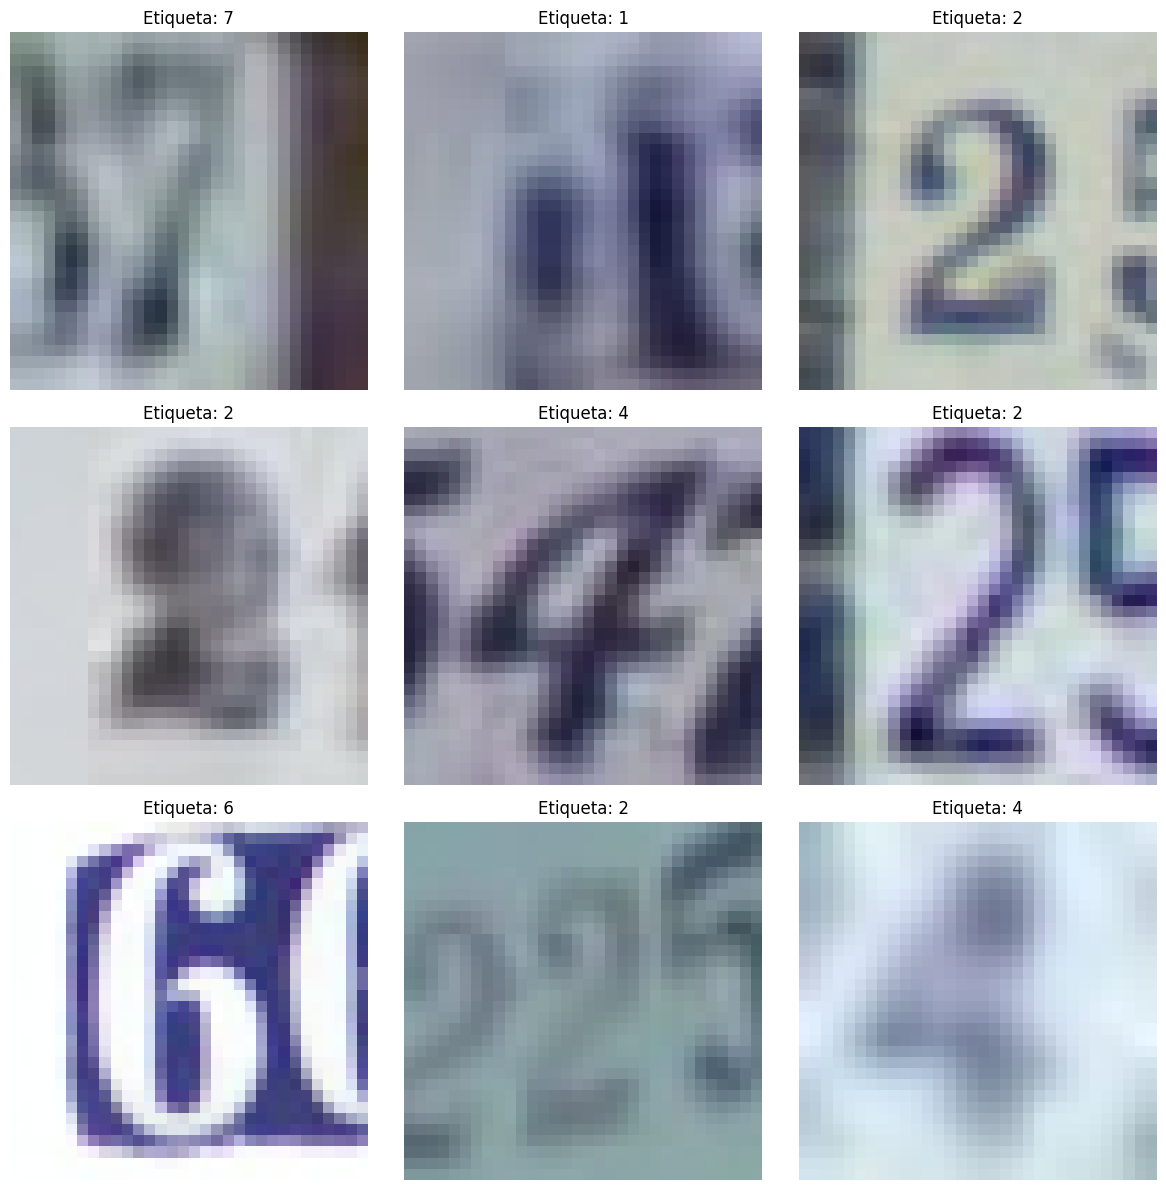

In [31]:
# Mostrar múltiples imágenes
display_many(X_train[:9], [f"Etiqueta: {y}" for y in y_train[:9]], 3, 3)


In [32]:
y_train = np.where(y_train == 10, 0, y_train)
y_val = np.where(y_val == 10, 0, y_val)
y_test = np.where(y_test == 10, 0, y_test)

valores, cuantos = np.unique(y_train, return_counts=True)
df = pd.DataFrame({
    'Valor': valores,
    'Cuantos': cuantos
})
print(df)

   Valor  Cuantos
0      0     3989
1      1    11015
2      2     8452
3      3     6807
4      4     6018
5      5     5505
6      6     4574
7      7     4472
8      8     4031
9      9     3742


In [21]:
# Normalizar los datos
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

print(X_train[0])

[[[0.5372549  0.60392157 0.56470588]
  [0.5372549  0.60392157 0.56862745]
  [0.54901961 0.61568627 0.58823529]
  ...
  [0.23921569 0.20392157 0.17254902]
  [0.23137255 0.19607843 0.14117647]
  [0.21568627 0.18039216 0.10980392]]

 [[0.49803922 0.56862745 0.52941176]
  [0.49019608 0.56078431 0.5254902 ]
  [0.50588235 0.57254902 0.54509804]
  ...
  [0.25490196 0.21568627 0.2       ]
  [0.24705882 0.20392157 0.16470588]
  [0.23137255 0.18823529 0.12156863]]

 [[0.45098039 0.51764706 0.49019608]
  [0.43137255 0.49803922 0.47058824]
  [0.43921569 0.49803922 0.47843137]
  ...
  [0.2745098  0.23529412 0.23137255]
  [0.27058824 0.22352941 0.19215686]
  [0.25490196 0.20392157 0.14901961]]

 ...

 [[0.60784314 0.64313725 0.67843137]
  [0.60784314 0.64705882 0.68235294]
  [0.60784314 0.64705882 0.68627451]
  ...
  [0.2627451  0.19607843 0.25882353]
  [0.2745098  0.20392157 0.25098039]
  [0.27843137 0.2        0.23921569]]

 [[0.65882353 0.69803922 0.73333333]
  [0.65882353 0.69803922 0.73333333]


Epoch 1/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.1244 - loss: 73.3091 - val_accuracy: 0.1144 - val_loss: 2.5083
Epoch 2/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.2512 - loss: 2.2227 - val_accuracy: 0.3988 - val_loss: 1.8469
Epoch 3/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4486 - loss: 1.7033 - val_accuracy: 0.5476 - val_loss: 1.4483
Epoch 4/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.5457 - loss: 1.4643 - val_accuracy: 0.6014 - val_loss: 1.3266
Epoch 5/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5611 - loss: 1.4111 - val_accuracy: 0.4693 - val_loss: 1.8668
Epoch 6/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5834 - loss: 1.3559 - val_accuracy: 0.5439 - val_loss: 1.5297
Epoch 7/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.6081 - loss: 1.2679 - val_accuracy: 0.6680 - val_loss: 1.0872
Epoch 8/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.6247 - loss: 

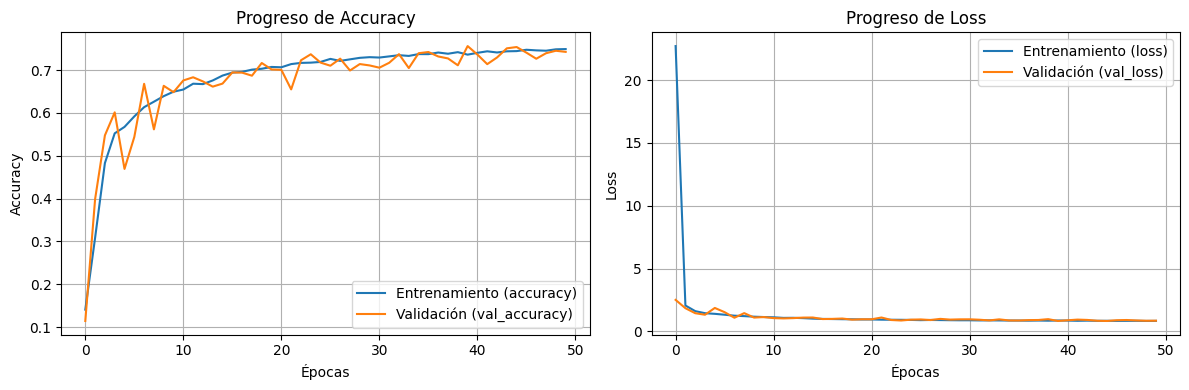

In [33]:
# Construir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "Checkpoints/svhn_model.weights.h5", 
    save_best_only=True,
    save_weights_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", 
    patience=10, 
    restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb],
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento (accuracy)')
plt.plot(history.history['val_accuracy'], label='Validación (val_accuracy)')
plt.title('Progreso de Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento (loss)')
plt.plot(history.history['val_loss'], label='Validación (val_loss)')
plt.title('Progreso de Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de test: {test_acc}")

2290/2290 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7682 - loss: 0.7779
Precisión en el conjunto de test: 0.7648689150810242


Índice seleccionado: 57680


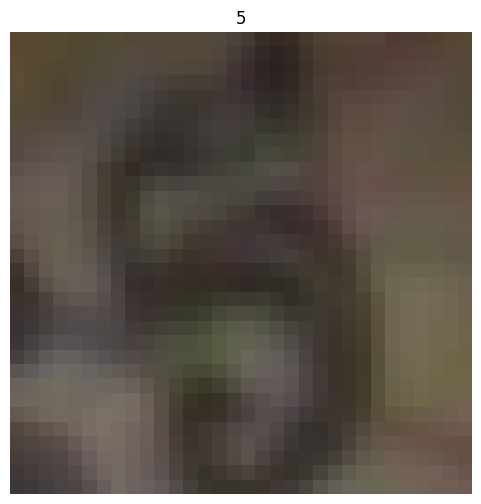

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicción de la clase: 8


In [35]:
# Selección aleatoria de un índice
indice_aleatorio = np.random.randint(0, len(X_test))
print(f"Índice seleccionado: {indice_aleatorio}")

# Mostrar la imagen
display_image(X_test[indice_aleatorio], y_test[indice_aleatorio])

# Realizar la predicción
prediccion = model.predict(np.expand_dims(X_test[indice_aleatorio], axis=0))  # Expandir dimensión para que sea (1, 32, 32, 3)

# Obtener la clase con la mayor probabilidad
prediccion_clase = np.argmax(prediccion, axis=1)

print(f"Predicción de la clase: {prediccion_clase[0]}")


## EJERCICIO 4

Predicción del consumo de energía:

* Objetivo: Construir una red neuronal para predecir el consumo de energía de edificios a partir de características como la temperatura, humedad, y tiempo del conjunto de datos Energy Efficiency de UCI Machine Learning Repository

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos, preparar los datos (normalizar con una capa de normalización), construir un modelo de regresión, compilar y entrenar una red neuronal. 
    
    * Usa X1-X8 para la X e Y1-Y2 para la y

    * Ajusta el modelo hasta encontrar un error absoluto medio aceptable

    * Haz una gráfica de como evoluciona el error absoluto medio y error absoluto medio del conjunto de validación durante el entrenamiento

    * Evalúa el modelo en el conjunto de test y haz alguna predicción (muestra el valor predicho y el real)

In [36]:
# Descargar el conjunto de datos de eficiencia energética de UCI
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx")
data = pd.read_excel(url)

In [37]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [39]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


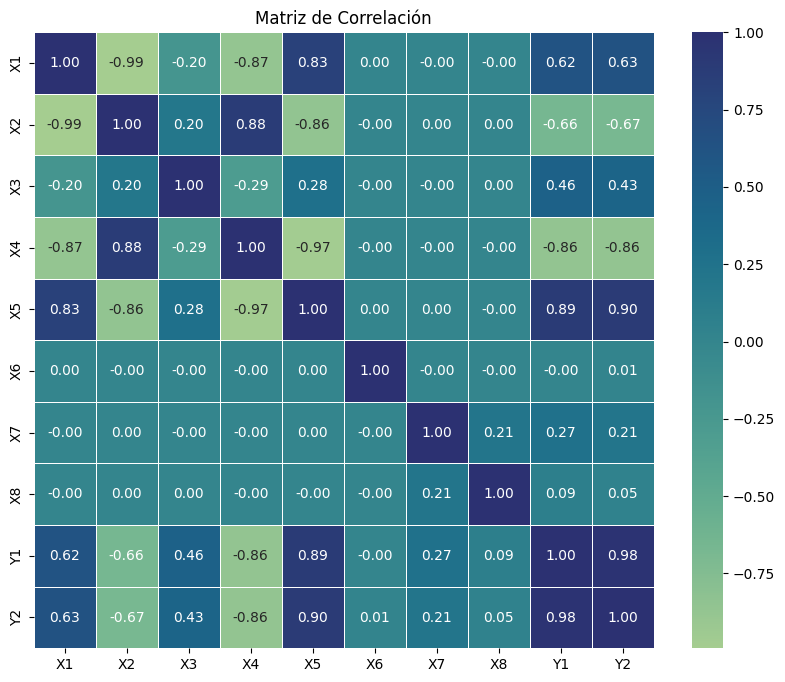

In [40]:
# Matriz de correlación
correlation_matrix = data.corr()

# Mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show() 

In [41]:
# Las menos correlacionadas no me interesan
X = data[["X1", "X2", "X3", "X4", "X5", "X7"]]
y = data[["Y1", "Y2"]]
print(X.head())
print(y.head())

     X1     X2     X3      X4   X5   X7
0  0.98  514.5  294.0  110.25  7.0  0.0
1  0.98  514.5  294.0  110.25  7.0  0.0
2  0.98  514.5  294.0  110.25  7.0  0.0
3  0.98  514.5  294.0  110.25  7.0  0.0
4  0.90  563.5  318.5  122.50  7.0  0.0
      Y1     Y2
0  15.55  21.33
1  15.55  21.33
2  15.55  21.33
3  15.55  21.33
4  20.84  28.28


In [42]:
# Separar los datos
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Tamaño de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Tamaño de validación: {X_valid.shape}, {y_valid.shape}")
print(f"Tamaño de prueba: {X_test.shape}, {y_test.shape}")

Tamaño de entrenamiento: (537, 6), (537, 2)
Tamaño de validación: (115, 6), (115, 2)
Tamaño de prueba: (116, 6), (116, 2)


In [43]:
# Crear una capa de normalización
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# Construir la red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2) # 2 salidas
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 6)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,751 (18.56 KB)

 Trainable params: 4,738 (18.51 KB)

 Non-trainable params: 13 (56.00 B)

In [44]:
# Entrenar el modelo
history = model.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.9244 - mae: 18.9244 - val_loss: 5.7426 - val_mae: 5.7426
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1940 - mae: 5.1940 - val_loss: 4.5545 - val_mae: 4.5545
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8437 - mae: 3.8437 - val_loss: 3.4112 - val_mae: 3.4112
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9207 - mae: 2.9207 - val_loss: 2.6900 - val_mae: 2.6900
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3455 - mae: 2.3455 - val_loss: 2.3664 - val_mae: 2.3664
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2575 - mae: 2.2575 - val_loss: 2.4184 - val_mae: 2.4184
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1210 - mae: 2.1210 - val_loss: 2.1755 - val_mae: 2.1755
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1494 - mae: 2.1494 - val_loss: 2.1080 - val_mae: 2.1080
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.

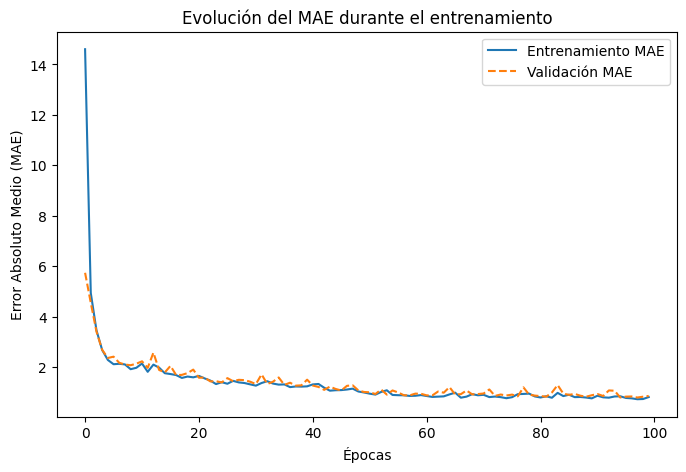

In [45]:
# MAE
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Entrenamiento MAE')
plt.plot(history.history['val_mae'], label='Validación MAE', linestyle='dashed')
plt.xlabel('Épocas')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.legend()
plt.title('Evolución del MAE durante el entrenamiento')
plt.show()

In [46]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"\nEvaluación en test: MAE = {test_mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8288 - mae: 0.8288 

Evaluación en test: MAE = 0.7941


In [47]:
# Hacer predicciones con el modelo entrenado
y_test = np.array(y_test)
predictions = model.predict(X_test[:5])  # Predecir las primeras 5 muestras

for i in range(5):
    print(f"Real      : {np.round(y_test[i], 3)}")
    print(f"Predicción: {np.round(predictions[i], 3)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Real      : [24.94 29.88]
Predicción: [25.588 27.226]
Real      : [35.45 41.86]
Predicción: [35.403 37.147]
Real      : [28.07 34.14]
Predicción: [27.851 30.818]
Real      : [ 8.6  12.07]
Predicción: [ 8.477 12.372]
Real      : [36.95 36.87]
Predicción: [35.57  36.017]



Entrenando con learning rate: 0.003
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.8410 - mae: 22.8410 - val_loss: 22.1050 - val_mae: 22.1050
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.7601 - mae: 18.7601 - val_loss: 11.1658 - val_mae: 11.1658
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2781 - mae: 7.2781 - val_loss: 5.6308 - val_mae: 5.6308
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3906 - mae: 4.3906 - val_loss: 4.2038 - val_mae: 4.2038
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5269 - mae: 3.5269 - val_loss: 3.8477 - val_mae: 3.8477
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2357 - mae: 3.2357 - val_loss: 3.2757 - val_mae: 3.2757
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6506 - mae: 2.6506 - val_loss: 2.9956 - val_mae: 2.9956
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6885 - mae: 2.6885 - val_loss: 2.6860 - val_mae: 2.6860
Epoch 9/100
17/17 

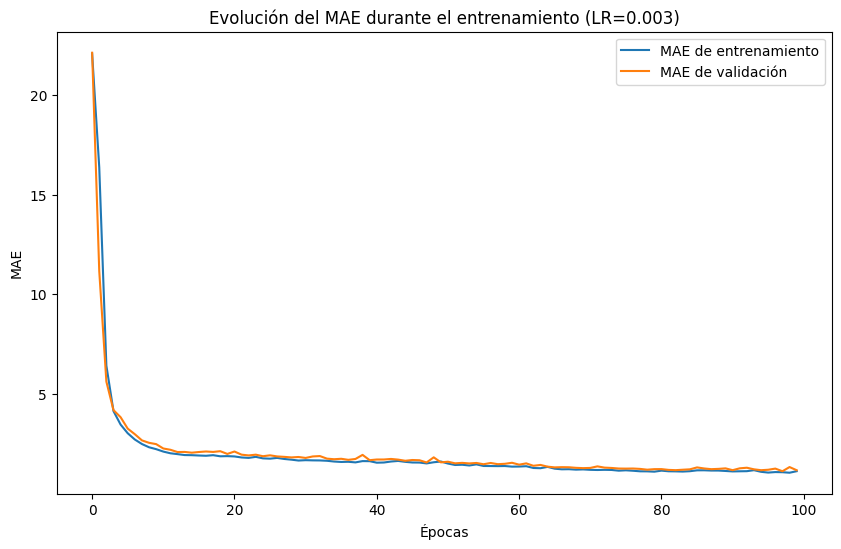

MAE en el conjunto de prueba: 1.03
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Real: [24.94 29.88]
Predicción: [31.954 31.399]
Diferencia: [7.014 1.519]
Real: [35.45 41.86]
Predicción: [36.293 36.614]
Diferencia: [ 0.843 -5.246]
Real: [28.07 34.14]
Predicción: [28.238 29.89 ]
Diferencia: [ 0.168 -4.25 ]
Real: [ 8.6  12.07]
Predicción: [ 9.007 13.081]
Diferencia: [0.407 1.011]
Real: [36.95 36.87]
Predicción: [36.938 37.384]
Diferencia: [-0.012  0.514]
Promedio de la diferencia absoluta (Y1, Y2): [0.78035791 1.27825593]

Entrenando con learning rate: 0.005
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.2069 - mae: 21.2069 - val_loss: 15.1478 - val_mae: 15.1478
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8525 - mae: 9.8525 - val_loss: 7.3635 - val_mae: 7.3635
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0937 - mae: 5.0937 - val_loss: 4.3363 - val_mae: 4.3363
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7770 - mae: 3.7770 - val_los

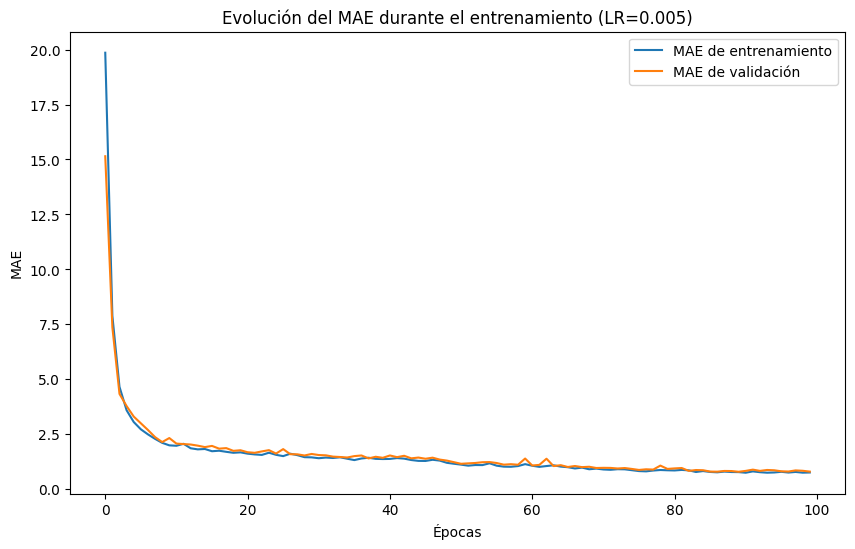

MAE en el conjunto de prueba: 0.76


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000258E26025C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Real: [24.94 29.88]
Predicción: [26.199 28.583]
Diferencia: [ 1.259 -1.297]
Real: [35.45 41.86]
Predicción: [35.914 36.941]
Diferencia: [ 0.464 -4.919]
Real: [28.07 34.14]
Predicción: [28.896 31.124]
Diferencia: [ 0.826 -3.016]
Real: [ 8.6  12.07]
Predicción: [ 8.396 11.844]
Diferencia: [-0.204 -0.226]
Real: [36.95 36.87]
Predicción: [36.017 36.823]
Diferencia: [-0.933 -0.047]
Promedio de la diferencia absoluta (Y1, Y2): [0.43638306 1.08865374]

Entrenando con learning rate: 0.007
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 19.8967 - mae: 19.8967 - val_loss: 9.5196 - val_mae: 9.5196
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8337 - mae: 6.8337 - val_loss: 4.3901 - val_mae: 4.3901
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7511 - mae: 3.7511 - val_loss: 3.5021 - val_mae: 3.5021
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8010 - mae: 2.8010 - val_loss: 2.9122 - val_mae: 2.9122
Epoch

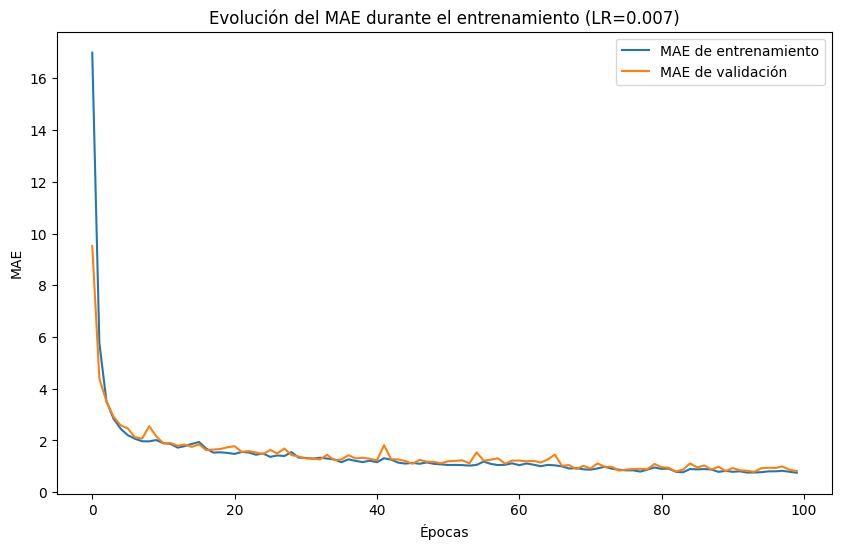

MAE en el conjunto de prueba: 0.79
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Real: [24.94 29.88]
Predicción: [26.676 27.84 ]
Diferencia: [ 1.736 -2.04 ]
Real: [35.45 41.86]
Predicción: [36.936 37.518]
Diferencia: [ 1.486 -4.342]
Real: [28.07 34.14]
Predicción: [29.392 30.609]
Diferencia: [ 1.322 -3.531]
Real: [ 8.6  12.07]
Predicción: [ 8.383 11.343]
Diferencia: [-0.217 -0.727]
Real: [36.95 36.87]
Predicción: [37.245 37.263]
Diferencia: [0.295 0.393]
Promedio de la diferencia absoluta (Y1, Y2): [0.43756713 1.13722755]

Entrenando con learning rate: 0.01
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.1754 - mae: 18.1754 - val_loss: 7.6393 - val_mae: 7.6393
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8126 - mae: 5.8126 - val_loss: 4.3256 - val_mae: 4.3256
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4147 - mae: 3.4147 - val_loss: 3.1993 - val_mae: 3.1993
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8897 - mae: 2.8897 - val_loss

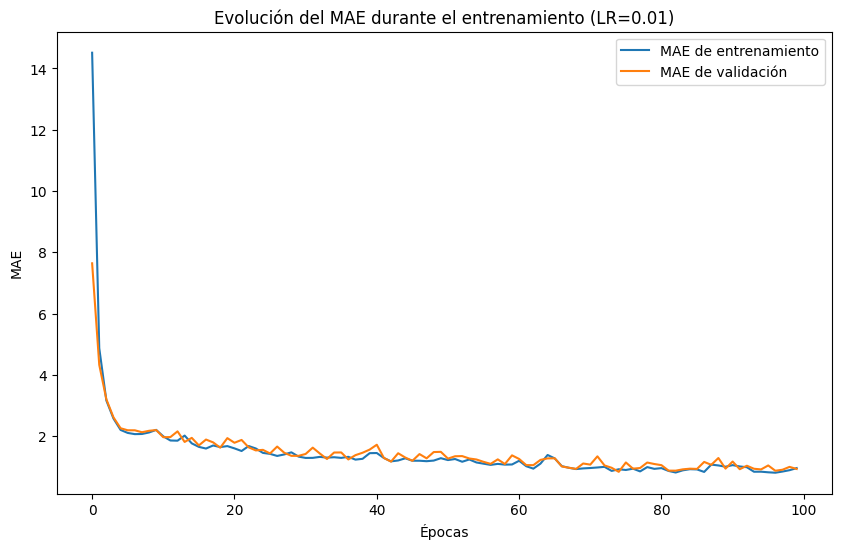

MAE en el conjunto de prueba: 0.86
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Real: [24.94 29.88]
Predicción: [26.284 28.182]
Diferencia: [ 1.344 -1.698]
Real: [35.45 41.86]
Predicción: [35.887 37.098]
Diferencia: [ 0.437 -4.762]
Real: [28.07 34.14]
Predicción: [29.047 30.878]
Diferencia: [ 0.977 -3.262]
Real: [ 8.6  12.07]
Predicción: [ 7.498 11.052]
Diferencia: [-1.102 -1.018]
Real: [36.95 36.87]
Predicción: [35.794 36.21 ]
Diferencia: [-1.156 -0.66 ]
Promedio de la diferencia absoluta (Y1, Y2): [0.52348851 1.19211779]

Entrenando con learning rate: 0.05
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 13.4363 - mae: 13.4363 - val_loss: 7.4079 - val_mae: 7.4079
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2489 - mae: 4.2489 - val_loss: 2.6985 - val_mae: 2.6985
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4330 - mae: 2.4330 - val_loss: 2.9340 - val_mae: 2.9340
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6182 - mae: 2.6182 - val_lo

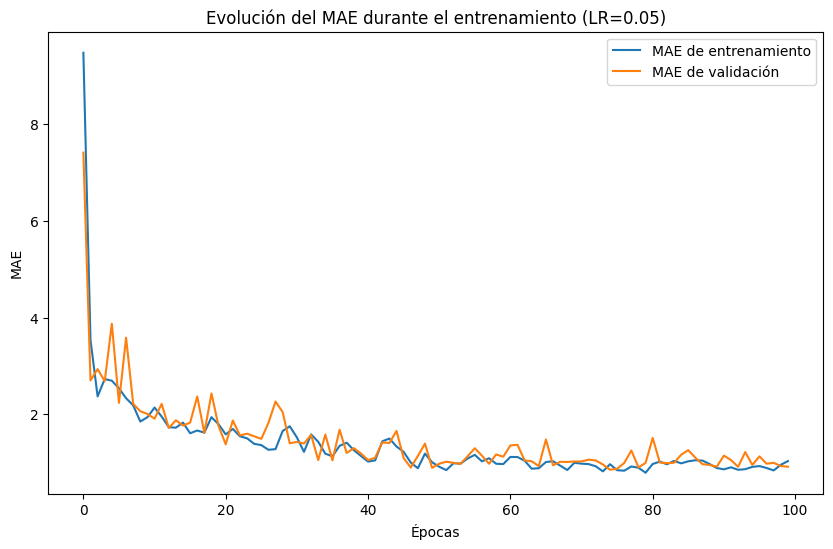

MAE en el conjunto de prueba: 0.89
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Real: [24.94 29.88]
Predicción: [26.403 28.628]
Diferencia: [ 1.463 -1.252]
Real: [35.45 41.86]
Predicción: [35.996 38.015]
Diferencia: [ 0.546 -3.845]
Real: [28.07 34.14]
Predicción: [28.021 30.709]
Diferencia: [-0.049 -3.431]
Real: [ 8.6  12.07]
Predicción: [ 8.294 11.805]
Diferencia: [-0.306 -0.265]
Real: [36.95 36.87]
Predicción: [36.279 37.24 ]
Diferencia: [-0.671  0.37 ]
Promedio de la diferencia absoluta (Y1, Y2): [0.64858574 1.1347172 ]

Entrenando con learning rate: 0.1
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 12.0668 - mae: 12.0668 - val_loss: 7.0074 - val_mae: 7.0074
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7147 - mae: 4.7147 - val_loss: 4.2231 - val_mae: 4.2231
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3265 - mae: 3.3265 - val_loss: 2.6335 - val_mae: 2.6335
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6151 - mae: 2.6151 - val_los

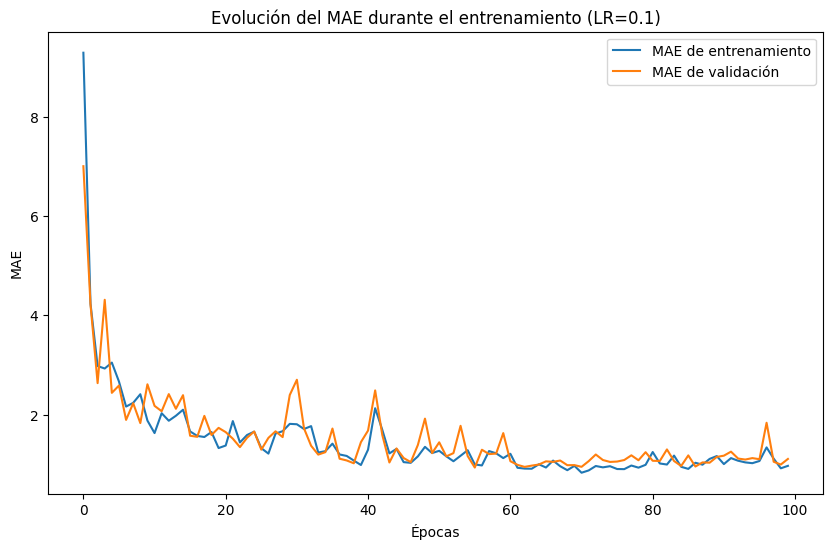

MAE en el conjunto de prueba: 0.99
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Real: [24.94 29.88]
Predicción: [25.948 26.965]
Diferencia: [ 1.008 -2.915]
Real: [35.45 41.86]
Predicción: [35.092 35.992]
Diferencia: [-0.358 -5.868]
Real: [28.07 34.14]
Predicción: [28.411 29.775]
Diferencia: [ 0.341 -4.365]
Real: [ 8.6  12.07]
Predicción: [ 8.024 11.169]
Diferencia: [-0.576 -0.901]
Real: [36.95 36.87]
Predicción: [35.172 34.316]
Diferencia: [-1.778 -2.554]
Promedio de la diferencia absoluta (Y1, Y2): [0.62280866 1.35678448]


In [48]:

# Lista de learning rates a probar
learning_rates = [0.003, 0.005, 0.007, 0.01, 0.05, 0.1]

# Diccionario para guardar los históricos
history_dict = {}

# Entrenar modelos con diferentes learning rates
for learning_rate in learning_rates:
    print(f"\nEntrenando con learning rate: {learning_rate}")

    # Construir la red neuronal
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        normalizer,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2)  # 2 salidas
    ])

    # Compilar el modelo con el learning rate actual
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mae', metrics=['mae'])

    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=100,
        batch_size=32,
        verbose=1
    )

    # Guardar el historial
    history_dict[learning_rate] = history

    # Graficar la evolución del error absoluto medio (MAE)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='MAE de entrenamiento')
    plt.plot(history.history['val_mae'], label='MAE de validación')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.title(f'Evolución del MAE durante el entrenamiento (LR={learning_rate})')
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"MAE en el conjunto de prueba: {test_mae:.2f}")

    # Realizar predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Mostrar algunas predicciones junto con sus valores reales
    for i in range(5):
        print(f"Real: {np.round(y_test[i], 3)}")
        print(f"Predicción: {np.round(predictions[i], 3)}")
        print(f"Diferencia: {np.round(predictions[i] - y_test[i], 3)}")

    # Calcular el promedio de la diferencia entre predicciones y valores reales
    differences = np.abs(predictions - y_test)  # Diferencias absolutas
    average_difference = np.mean(differences, axis=0)  # Promedio por columna
    print(f"Promedio de la diferencia absoluta (Y1, Y2): {average_difference}")


0.01 es el que mejor resultado me da